<a href="https://colab.research.google.com/github/tlacaelel666/QuoreMind-/blob/main/cuadranteQuoremindv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framework QuoreMind v1.0.0
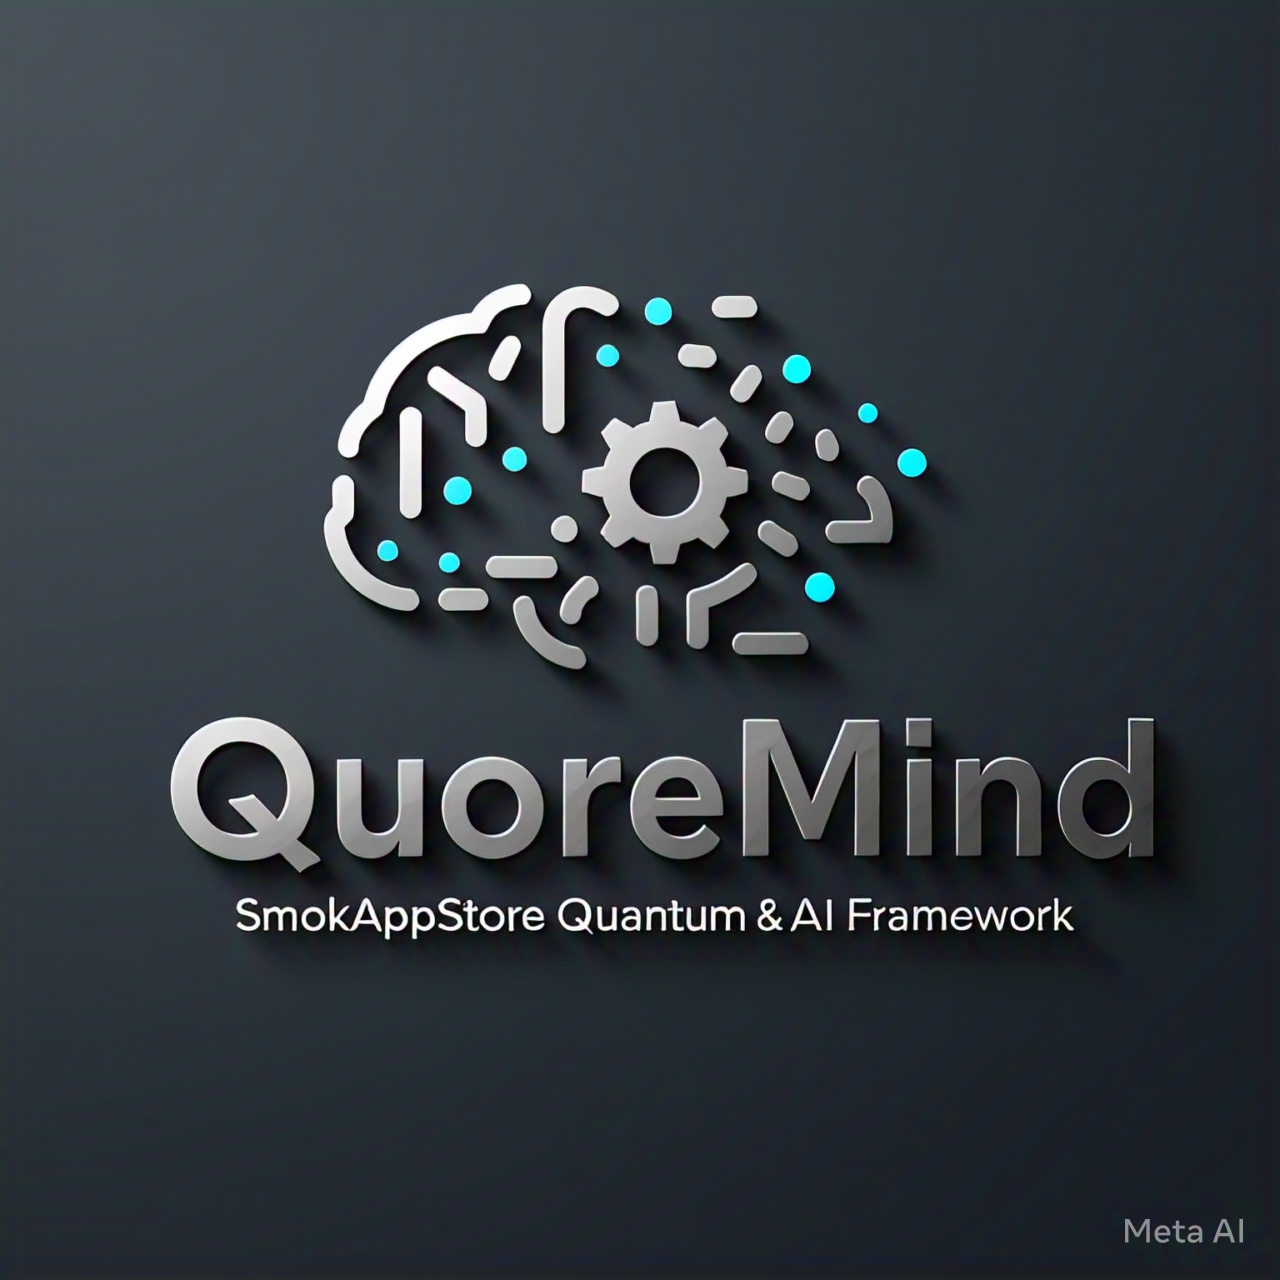

## Description

QuoreMind v1.0.0 es un framework en Python diseñado para la implementación de lógica bayesiana, análisis estadísticos y modelado del "Ruido Probabilístico de Referencia" (PRN), incorporando conceptos de entropía cuántica (entropía de von Neumann). Este proyecto busca proporcionar herramientas para analizar sistemas complejos desde una perspectiva probabilística y cuántica, permitiendo la toma de decisiones informadas basadas en la incertidumbre y la coherencia de los datos.

## Usage

QuoreMind v1.0.0 proporciona varias clases y funciones para realizar análisis bayesianos, estadísticos y modelado PRN.

### Instalación

Asegúrate de tener las dependencias instaladas ejecutando `pip install -r requirements.txt`.

## Code Structure

El framework QuoreMind v1.0.0 está organizado en varias clases y funciones para modularizar la lógica y los análisis:

*   **`EntropyType`**: Un enumerador para especificar el tipo de entropía a calcular (Shannon, Von Neumann, o ambos).
*   **Decoradores (`timer_decorator`, `validate_input_decorator`)**: Funciones para añadir funcionalidad extra (medición de tiempo, validación de entrada) a otras funciones.
*   **`BayesLogicConfig`**: Una dataclass para configurar parámetros utilizados por la clase `BayesLogic`.
*   **`BayesLogic`**: Implementa la lógica bayesiana para calcular probabilidades posteriores, condicionales y conjuntas, y para tomar decisiones basadas en umbrales.
*   **`StatisticalAnalysis`**: Contiene métodos para realizar análisis estadísticos, incluyendo el cálculo de la entropía de Shannon y la entropía de von Neumann, la creación de matrices de densidad, el cálculo de cosenos direccionales, la matriz de covarianza y la distancia de Mahalanobis.
*   **`ComplexPRN`**: Clase para modelar el Ruido Probabilístico de Referencia (PRN) como números complejos, incluyendo su influencia y fase.
*   **`PRN`**: Clase general para modelar el Ruido Probabilístico de Referencia con un factor de influencia y métodos para ajustarla y combinar PRNs.
*   **Funciones de demostración (`run_bayes_logic_example`, `run_advanced_quantum_analysis`, `run_statistical_analysis_demo`, `run_prn_evolution_simulation`)**: Funciones que demuestran el uso de las diferentes partes del framework con ejemplos concretos.
*   **`main()`**: La función principal que orquesta la ejecución de las funciones de demostración.

## Contributing

Si deseas contribuir a QuoreMind v1.0.0, por favor sigue estos pasos:

1.  Haz un fork del repositorio.
2.  Crea una nueva rama para tu característica (`git checkout -b f`).
3.  Realiza tus cambios y asegúrate de que el código pase las pruebas.
4.  Haz commit de tus cambios (`git commit -m ''`).
5.  Haz push a la rama (`git push origin `).
6.  Abre un Pull Request.

In [1]:
%pip install numpy tensorflow tensorflow-probability scipy scikit-learn

In [3]:
"""Este marco de trabajo en Python proporciona herramientas para implementar lógica bayesiana, realizar análisis estadísticos y modelar el "Ruido Probabilístico de Referencia" (PRN).
Incluye implementación de entropía de von Neumann para sistemas cuánticos.
Fecha: 4-4-2025.
autor: Jacobo Tlacaelel Mina Rodríguez
proyecto: QuoreMind v1.0.0
"""
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Tuple, List, Dict, Union, Any, Optional, Callable
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance
from scipy.linalg import logm, sqrtm
import functools
import time
from dataclasses import dataclass
from enum import Enum


class EntropyType(Enum):
    """Enum para especificar el tipo de entropía a calcular."""
    SHANNON = "shannon"
    VON_NEUMANN = "von_neumann"
    BOTH = "both"


def timer_decorator(func: Callable) -> Callable:
    """
    Decorador que mide el tiempo de ejecución de una función.

    Args:
        func: La función a medir.

    Returns:
        La función decorada que muestra el tiempo de ejecución.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Función {func.__name__} ejecutada en {end_time - start_time:.4f} segundos")
        return result
    return wrapper


def validate_input_decorator(min_val: float = 0.0, max_val: float = 1.0) -> Callable:
    """
    Decorador que valida que los argumentos numéricos estén en un rango específico.

    Args:
        min_val: Valor mínimo permitido.
        max_val: Valor máximo permitido.

    Returns:
        La función decorada con validación de rango.
    """
    def decorator(func: Callable) -> Callable:
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # Validar args que sean floats (ignorar self si es un método)
            for i, arg in enumerate(args[1:], 1):
                if isinstance(arg, (int, float)) and not (min_val <= arg <= max_val):
                    raise ValueError(f"Argumento {i} debe estar entre {min_val} y {max_val}. Valor recibido: {arg}")

            # Validar kwargs que sean floats
            for name, arg in kwargs.items():
                if isinstance(arg, (int, float)) and not (min_val <= arg <= max_val):
                    raise ValueError(f"Argumento {name} debe estar entre {min_val} y {max_val}. Valor recibido: {arg}")

            return func(*args, **kwargs)
        return wrapper
    return decorator


@dataclass
class BayesLogicConfig:
    """Configuración para la clase BayesLogic."""
    epsilon: float = 1e-6
    high_entropy_threshold: float = 0.8
    high_coherence_threshold: float = 0.6
    action_threshold: float = 0.5
    entropy_type: EntropyType = EntropyType.SHANNON


class BayesLogic:
    """
    Clase para calcular probabilidades y seleccionar acciones basadas en el teorema de Bayes.

    Provee métodos para:
      - Calcular la probabilidad posterior usando Bayes.
      - Calcular probabilidades condicionales.
      - Derivar probabilidades previas en función de la entropía y la coherencia.
      - Calcular probabilidades conjuntas a partir de la coherencia, acción e influencia.
      - Seleccionar la acción final según un umbral predefinido.
    """
    def __init__(self, config: Optional[BayesLogicConfig] = None):
        """
        Inicializa una instancia de BayesLogic con la configuración proporcionada.

        Args:
            config: Configuración opcional para la clase BayesLogic.
                   Si no se proporciona, se usa la configuración por defecto.
        """
        self.config = config or BayesLogicConfig()

    @validate_input_decorator(0.0, 1.0)
    def calculate_posterior_probability(self, prior_a: float, prior_b: float, conditional_b_given_a: float) -> float:
        """
        Calcula la probabilidad posterior usando el teorema de Bayes:
            P(A|B) = (P(B|A) * P(A)) / P(B)

        Args:
            prior_a: Probabilidad previa de A.
            prior_b: Probabilidad previa de B.
            conditional_b_given_a: Probabilidad condicional de B dado A.

        Returns:
            La probabilidad posterior P(A|B).
        """
        # Evitamos división por cero
        prior_b = max(prior_b, self.config.epsilon)
        return (conditional_b_given_a * prior_a) / prior_b

    @validate_input_decorator(0.0, 1.0)
    def calculate_conditional_probability(self, joint_probability: float, prior: float) -> float:
        """
        Calcula la probabilidad condicional a partir de una probabilidad conjunta y una probabilidad previa.

        Args:
            joint_probability: Probabilidad conjunta de dos eventos.
            prior: Probabilidad previa del evento.

        Returns:
            La probabilidad condicional resultante.
        """
        prior = max(prior, self.config.epsilon)
        return joint_probability / prior

    @validate_input_decorator(0.0, 1.0)
    def calculate_high_entropy_prior(self, entropy: float) -> float:
        """
        Deriva una probabilidad previa en función del valor de entropía.

        Args:
            entropy: Valor de entropía entre 0 y 1.

        Returns:
            Retorna 0.3 si la entropía supera el umbral, o 0.1 en otro caso.
        """
        return 0.3 if entropy > self.config.high_entropy_threshold else 0.1

    @validate_input_decorator(0.0, 1.0)
    def calculate_high_coherence_prior(self, coherence: float) -> float:
        """
        Deriva una probabilidad previa en función del valor de coherencia.

        Args:
            coherence: Valor de coherencia entre 0 y 1.

        Returns:
            Retorna 0.6 si la coherencia supera el umbral, o 0.2 en otro caso.
        """
        return 0.6 if coherence > self.config.high_coherence_threshold else 0.2

    @validate_input_decorator(0.0, 1.0)
    def calculate_joint_probability(self, coherence: float, action: int, prn_influence: float) -> float:
        """
        Calcula la probabilidad conjunta de A y B basándose en la coherencia, la acción e influencia PRN.

        Args:
            coherence: Valor de coherencia entre 0 y 1.
            action: Indicador de acción (1 para acción positiva, 0 para negativa).
            prn_influence: Factor de influencia PRN entre 0 y 1.

        Returns:
            Probabilidad conjunta resultante entre 0 y 1.
        """
        if coherence > self.config.high_coherence_threshold:
            if action == 1:
                # Si la acción es positiva, la influencia alta del PRN aumenta la probabilidad
                return prn_influence * 0.8 + (1 - prn_influence) * 0.2
            else:
                # Si la acción es negativa, la influencia alta del PRN disminuye la probabilidad
                return prn_influence * 0.1 + (1 - prn_influence) * 0.7
        # Para coherencia baja, usamos un valor intermedio fijo
        return 0.3

    @timer_decorator
    @validate_input_decorator(0.0, 1.0)
    def calculate_probabilities_and_select_action(
        self, entropy: float, coherence: float, prn_influence: float, action: int
    ) -> Dict[str, float]:
        """
        Integra los cálculos bayesianos para determinar la acción a tomar.

        Args:
            entropy: Valor de entropía entre 0 y 1.
            coherence: Valor de coherencia entre 0 y 1.
            prn_influence: Factor de influencia PRN entre 0 y 1.
            action: Indicador de acción (1 o 0).

        Returns:
            Diccionario con los resultados del análisis y la acción a tomar.
        """
        high_entropy_prior = self.calculate_high_entropy_prior(entropy)
        high_coherence_prior = self.calculate_high_coherence_prior(coherence)

        # La probabilidad condicional se ajusta según el nivel de entropía
        conditional_b_given_a = (
            prn_influence * 0.7 + (1 - prn_influence) * 0.3
            if entropy > self.config.high_entropy_threshold else 0.2
        )

        # Cálculo del posterior usando el teorema de Bayes
        posterior_a_given_b = self.calculate_posterior_probability(
            high_entropy_prior, high_coherence_prior, conditional_b_given_a
        )

        # Probabilidad conjunta basada en coherencia, acción e influencia PRN
        joint_probability_ab = self.calculate_joint_probability(
            coherence, action, prn_influence
        )

        # Probabilidad condicional de la acción dado B
        conditional_action_given_b = self.calculate_conditional_probability(
            joint_probability_ab, high_coherence_prior
        )

        # Decisión final basada en el umbral de acción
        action_to_take = 1 if conditional_action_given_b > self.config.action_threshold else 0

        return {
            "action_to_take": action_to_take,
            "high_entropy_prior": high_entropy_prior,
            "high_coherence_prior": high_coherence_prior,
            "posterior_a_given_b": posterior_a_given_b,
            "conditional_action_given_b": conditional_action_given_b
        }


class StatisticalAnalysis:
    """Clase que agrupa funciones de análisis estadístico incluyendo entropías clásicas y cuánticas."""

    @staticmethod
    def shannon_entropy(data: List[Any]) -> float:
        """
        Calcula la entropía de Shannon para un conjunto de datos.

        Args:
            data: Datos de entrada.

        Returns:
            Entropía en bits.
        """
        values, counts = np.unique(data, return_counts=True)
        probabilities = counts / len(data)
        probabilities = probabilities[probabilities > 0]  # Evita log(0)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    @staticmethod
    def create_density_matrix(eigenvalues: List[float]) -> np.ndarray:
        """
        Crea una matriz de densidad a partir de valores propios.

        Args:
            eigenvalues: Lista de valores propios (deben sumar 1).

        Returns:
            Matriz de densidad como array de NumPy.
        """
        eigenvalues = np.array(eigenvalues)

        # Normalizar para que sumen 1
        if not np.isclose(np.sum(eigenvalues), 1.0, rtol=1e-10):
            print(f"ADVERTENCIA: Normalizando eigenvalues (suma actual: {np.sum(eigenvalues)})")
            eigenvalues = eigenvalues / np.sum(eigenvalues)

        # Crear matriz diagonal
        n = len(eigenvalues)
        density_matrix = np.diag(eigenvalues)

        return density_matrix

    @staticmethod
    def create_mixed_state_density_matrix(state_probs: List[float], dim: int = 2) -> np.ndarray:
        """
        Crea una matriz de densidad para un estado mixto más realista.

        Args:
            state_probs: Probabilidades de los estados base.
            dim: Dimensión del sistema cuántico.

        Returns:
            Matriz de densidad como array de NumPy.
        """
        state_probs = np.array(state_probs)

        # Normalizar probabilidades
        if not np.isclose(np.sum(state_probs), 1.0, rtol=1e-10):
            state_probs = state_probs / np.sum(state_probs)

        # Crear estados base puros |0⟩, |1⟩, etc.
        basis_states = []
        for i in range(len(state_probs)):
            state = np.zeros(dim)
            state[i % dim] = 1.0
            basis_states.append(np.outer(state, state.conj()))

        # Combinar estados según las probabilidades
        density_matrix = np.zeros((dim, dim), dtype=complex)
        for i, prob in enumerate(state_probs):
            if i < len(basis_states):
                density_matrix += prob * basis_states[i]

        return density_matrix

    @staticmethod
    def von_neumann_entropy(density_matrix: np.ndarray, base: str = 'natural') -> float:
        """
        Calcula la entropía de von Neumann para una matriz de densidad cuántica.

        S(ρ) = -Tr(ρ log(ρ))

        Args:
            density_matrix: Matriz de densidad del sistema cuántico.
            base: Base del logaritmo ('natural' para ln, '2' para log2).

        Returns:
            Entropía de von Neumann.
        """
        # Verificar que es una matriz cuadrada
        if density_matrix.shape[0] != density_matrix.shape[1]:
            raise ValueError("La matriz de densidad debe ser cuadrada")

        # Verificar hermiticidad (aproximadamente)
        if not np.allclose(density_matrix, density_matrix.conj().T, rtol=1e-10, atol=1e-12):
            print("ADVERTENCIA: La matriz no es exactamente hermítica")

        # Verificar traza = 1
        trace = np.trace(density_matrix).real
        if not np.isclose(trace, 1.0, rtol=1e-10):
            print(f"ADVERTENCIA: Traza de la matriz de densidad: {trace} (debería ser 1)")

        # Calcular valores propios
        eigenvalues = np.linalg.eigvals(density_matrix)
        eigenvalues = eigenvalues.real  # Tomar parte real (los imaginarios deberían ser ~0)

        # Filtrar valores propios muy pequeños o negativos por errores numéricos
        eigenvalues = eigenvalues[eigenvalues > 1e-12]

        if len(eigenvalues) == 0:
            return 0.0

        # Calcular entropía de von Neumann
        if base == '2':
            entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
        else:  # base natural
            entropy = -np.sum(eigenvalues * np.log(eigenvalues))

        return entropy.real

    @staticmethod
    def von_neumann_entropy_matrix_log(density_matrix: np.ndarray, base: str = 'natural') -> float:
        """
        Calcula la entropía de von Neumann usando logaritmo matricial.

        S(ρ) = -Tr(ρ log(ρ))

        Args:
            density_matrix: Matriz de densidad del sistema cuántico.
            base: Base del logaritmo ('natural' para ln, '2' para log2).

        Returns:
            Entropía de von Neumann usando método de logaritmo matricial.
        """
        try:
            # Método usando logaritmo matricial
            log_rho = logm(density_matrix)

            if base == '2':
                log_rho = log_rho / np.log(2)  # Cambio de base

            entropy = -np.trace(density_matrix @ log_rho).real
            return entropy

        except Exception as e:
            print(f"Error en logaritmo matricial: {e}")
            # Fallback al método de eigenvalores
            return StatisticalAnalysis.von_neumann_entropy(density_matrix, base)

    @staticmethod
    def calculate_entropy(data: Union[List[Any], np.ndarray],
                         entropy_type: EntropyType = EntropyType.SHANNON,
                         **kwargs) -> Union[float, Dict[str, float]]:
        """
        Calcula entropía según el tipo especificado.

        Args:
            data: Datos de entrada (lista para Shannon, matriz para von Neumann).
            entropy_type: Tipo de entropía a calcular.
            **kwargs: Argumentos adicionales específicos del tipo de entropía.

        Returns:
            Valor de entropía o diccionario con ambos valores.
        """
        if entropy_type == EntropyType.SHANNON:
            if isinstance(data, np.ndarray) and data.ndim == 2:
                # Si es una matriz, extraer eigenvalores para Shannon
                eigenvals = np.linalg.eigvals(data).real
                eigenvals = eigenvals[eigenvals > 0]
                eigenvals = eigenvals / np.sum(eigenvals)  # Normalizar
                # Convertir a conteos ficticios para Shannon
                counts = (eigenvals * 1000).astype(int)
                fake_data = []
                for i, count in enumerate(counts):
                    fake_data.extend([i] * count)
                return StatisticalAnalysis.shannon_entropy(fake_data)
            else:
                return StatisticalAnalysis.shannon_entropy(data)

        elif entropy_type == EntropyType.VON_NEUMANN:
            if not isinstance(data, np.ndarray) or data.ndim != 2:
                raise ValueError("Para entropía de von Neumann se requiere una matriz de densidad 2D")
            base = kwargs.get('base', 'natural')
            method = kwargs.get('method', 'eigenvalues')

            if method == 'matrix_log':
                return StatisticalAnalysis.von_neumann_entropy_matrix_log(data, base)
            else:
                return StatisticalAnalysis.von_neumann_entropy(data, base)

        elif entropy_type == EntropyType.BOTH:
            shannon_val = StatisticalAnalysis.calculate_entropy(data, EntropyType.SHANNON)
            if isinstance(data, np.ndarray) and data.ndim == 2:
                von_neumann_val = StatisticalAnalysis.calculate_entropy(data, EntropyType.VON_NEUMANN, **kwargs)
            else:
                # Crear una matriz de densidad simple desde los datos
                if isinstance(data, list):
                    probs = np.array([data.count(x) for x in set(data)]) / len(data)
                    density_matrix = StatisticalAnalysis.create_density_matrix(probs)
                    von_neumann_val = StatisticalAnalysis.calculate_entropy(density_matrix, EntropyType.VON_NEUMANN, **kwargs)
                else:
                    von_neumann_val = 0.0

            return {
                'shannon': shannon_val,
                'von_neumann': von_neumann_val
            }

    @staticmethod
    def calculate_cosines(entropy: float, prn_object: float) -> Tuple[float, float, float]:
        """
        Calcula los cosenos direccionales (x, y, z) para un vector 3D.

        Args:
            entropy: Valor de entropía (componente x).
            prn_object: Valor del ambiente de ruido (componente y).

        Returns:
            (cos_x, cos_y, cos_z) correspondientes a cada dirección.
        """
        # Evitar división por cero
        epsilon = 1e-6
        entropy = max(entropy, epsilon)
        prn_object = max(prn_object, epsilon)

        magnitude = np.sqrt(entropy ** 2 + prn_object ** 2 + 1)
        cos_x = entropy / magnitude
        cos_y = prn_object / magnitude
        cos_z = 1 / magnitude
        return cos_x, cos_y, cos_z

    @staticmethod
    def calculate_covariance_matrix(data: Union[tf.Tensor, np.ndarray]) -> np.ndarray:
        """
        Calcula la matriz de covarianza de un conjunto de datos usando scikit-learn.

        Args:
            data: Tensor de datos (dtype tf.float32) o array de NumPy.

        Returns:
            Matriz de covarianza evaluada como un array de NumPy.
        """
        if isinstance(data, tf.Tensor):
            data_array = data.numpy()
        else:
            data_array = data

        if data_array.ndim != 2:
             raise ValueError("Los datos de entrada deben ser 2D para calcular la matriz de covarianza.")

        covariance_estimator = EmpiricalCovariance().fit(data_array)
        cov_matrix = covariance_estimator.covariance_
        return cov_matrix

    @staticmethod
    def calculate_covariance_between_two_variables(data: Union[tf.Tensor, np.ndarray]) -> float:
        """
        Calcula la covarianza entre dos variables usando scikit-learn.

        Args:
            data: Tensor de datos de dos variables (dtype tf.float32) o array de NumPy.

        Returns:
            La covarianza entre las dos variables.
        """
        if isinstance(data, tf.Tensor):
            data_array = data.numpy()
        else:
            data_array = data

        if data_array.ndim != 2 or data_array.shape[1] != 2:
             raise ValueError("Los datos de entrada deben ser 2D con exactamente 2 columnas para calcular la covarianza entre dos variables.")

        covariance_estimator = EmpiricalCovariance().fit(data_array)
        cov_matrix = covariance_estimator.covariance_
        # La covarianza entre las dos variables está en la posición [0, 1] o [1, 0]
        return cov_matrix[0, 1]

    @staticmethod
    @timer_decorator
    def compute_mahalanobis_distance(data: List[List[float]], point: List[float]) -> float:
        """
        Calcula la distancia de Mahalanobis entre un punto y un conjunto de datos.

        Args:
            data: Conjunto de datos, donde cada fila es una observación.
            point: Punto para el cual se calcula la distancia.

        Returns:
            La distancia de Mahalanobis.
        """
        data_array = np.array(data)
        point_array = np.array(point)

        # Estimar la matriz de covarianza empírica
        covariance_estimator = EmpiricalCovariance().fit(data_array)
        cov_matrix = covariance_estimator.covariance_
        print("Matriz de covarianza:")
        print(cov_matrix)

        try:
            # Intentamos calcular la inversa de la matriz de covarianza
            inv_cov_matrix = np.linalg.inv(cov_matrix)
        except np.linalg.LinAlgError:
            # Si no es invertible, usamos la pseudo-inversa
            print("ADVERTENCIA: Matriz de covarianza singular, usando pseudo-inversa")
            inv_cov_matrix = np.linalg.pinv(cov_matrix)

        # Calculamos el vector de medias
        mean_vector = np.mean(data_array, axis=0)

        # Calculamos la distancia de Mahalanobis
        distance = mahalanobis(point_array, mean_vector, inv_cov_matrix)
        return distance


class ComplexPRN:
    """
    Clase PRN modificada para representar números complejos.
    """
    def __init__(self, real_component: float, imaginary_component: float,
                 algorithm_type: Optional[str] = None, **parameters):
        """
        Inicializa un PRN complejo.

        Args:
            real_component: Componente real del número complejo.
            imaginary_component: Componente imaginaria del número complejo.
            algorithm_type: Tipo de algoritmo a utilizar.
            **parameters: Parámetros adicionales específicos del algoritmo.
        """
        self.real_component = real_component
        self.imaginary_component = imaginary_component
        # Módulo del número complejo como influencia
        self.influence = np.sqrt(real_component**2 + imaginary_component**2)
        self.algorithm_type = algorithm_type
        self.parameters = parameters

    def __str__(self) -> str:
        """Representación en string del objeto PRN complejo."""
        return (f"ComplexPRN(real={self.real_component:.4f}, "
                f"imag={self.imaginary_component:.4f}, "
                f"influence={self.influence:.4f})")

    def to_complex(self) -> complex:
        """Convierte el PRN complejo a un número complejo estándar de Python."""
        return complex(self.real_component, self.imaginary_component)

    def get_phase(self) -> float:
        """Calcula la fase del número complejo en radianes."""
        return np.arctan2(self.imaginary_component, self.real_component)

    def conjugate(self) -> 'ComplexPRN':
        """Retorna el conjugado complejo del PRN."""
        return ComplexPRN(self.real_component, -self.imaginary_component,
                         self.algorithm_type, **self.parameters)


class PRN:
    """
    Clase para modelar el Ruido Probabilístico de Referencia (Probabilistic Reference Noise).
    """
    def __init__(self, influence: float, algorithm_type: Optional[str] = None, **parameters):
        """
        Inicializa un objeto PRN con un factor de influencia y parámetros específicos.

        Args:
            influence: Factor de influencia entre 0 y 1.
            algorithm_type: Tipo de algoritmo a utilizar.
            **parameters: Parámetros adicionales específicos del algoritmo.
        """
        if not 0 <= influence <= 1:
            raise ValueError(f"La influencia debe estar entre 0 y 1. Valor recibido: {influence}")

        self.influence = influence
        self.algorithm_type = algorithm_type
        self.parameters = parameters

    def adjust_influence(self, adjustment: float) -> None:
        """
        Ajusta el factor de influencia dentro de los límites permitidos.

        Args:
            adjustment: Valor de ajuste (positivo o negativo).
        """
        new_influence = self.influence + adjustment
        # Truncamos al rango válido
        new_influence = max(0, min(1, new_influence))

        if new_influence != self.influence + adjustment:
            print(f"ADVERTENCIA: Influencia ajustada a {new_influence} para mantenerla en el rango [0,1]")

        self.influence = new_influence

    def combine_with(self, other_prn: 'PRN', weight: float = 0.5) -> 'PRN':
        """
        Combina este PRN con otro según un peso específico.

        Args:
            other_prn: Otro objeto PRN para combinar.
            weight: Peso para la combinación, entre 0 y 1 (por defecto 0.5).

        Returns:
            Un nuevo objeto PRN con la influencia combinada.
        """
        if not 0 <= weight <= 1:
            raise ValueError(f"El peso debe estar entre 0 y 1. Valor recibido: {weight}")

        # Combinación ponderada de las influencias
        combined_influence = self.influence * weight + other_prn.influence * (1 - weight)

        # Combinar los parámetros de ambos PRN
        combined_params = {**self.parameters, **other_prn.parameters}

        # Elegir el tipo de algoritmo según el peso
        algorithm = self.algorithm_type if weight >= 0.5 else other_prn.algorithm_type

        return PRN(combined_influence, algorithm, **combined_params)

    def __str__(self) -> str:
        """Representación en string del objeto PRN."""
        params_str = ", ".join(f"{k}={v}" for k, v in self.parameters.items())
        algo_str = f", algorithm={self.algorithm_type}" if self.algorithm_type else ""
        return f"PRN(influence={self.influence:.4f}{algo_str}{', ' + params_str if params_str else ''})"


# --- Funciones de demostración ---
def run_bayes_logic_example():
    """Ejecuta un ejemplo de uso de BayesLogic con valores predefinidos usando entropía de von Neumann."""
    print("\n" + "="*60)
    print("INICIANDO EJEMPLO DE QUOREMIND v1.0.0")
    print("="*60)

    # Crear una matriz de densidad cuántica de ejemplo
    print("\n1. Creando matriz de densidad cuántica...")
    density_matrix = StatisticalAnalysis.create_mixed_state_density_matrix([0.7, 0.3], dim=2)
    print(f"Matriz de densidad:")
    print(density_matrix)

    # Calcular entropía de von Neumann
    print("\n2. Calculando entropía de von Neumann...")
    von_neumann_entropy = StatisticalAnalysis.calculate_entropy(
        density_matrix,
        EntropyType.VON_NEUMANN,
        base='2'
    )
    print(f"Entropía de von Neumann: {von_neumann_entropy:.6f} bits")

    # También calcular entropía clásica para comparación
    print("\n3. Calculando entropía de Shannon clásica...")
    classical_data = [1, 2, 3, 4, 5, 5, 2, 1, 3, 2]
    shannon_entropy = StatisticalAnalysis.calculate_entropy(classical_data, EntropyType.SHANNON)
    print(f"Entropía de Shannon clásica: {shannon_entropy:.6f} bits")

    # Normalizar la entropía de von Neumann para usar en BayesLogic (0-1)
    # La entropía máxima para un sistema de 2 niveles es log2(2) = 1
    normalized_entropy = min(von_neumann_entropy / 1.0, 1.0)

    print(f"\n4. Configurando análisis bayesiano...")
    print(f"Entropía normalizada para análisis: {normalized_entropy:.6f}")

    # Crear instancia de BayesLogic con configuración personalizada
    config = BayesLogicConfig(
        epsilon=1e-8,
        high_entropy_threshold=0.7,
        high_coherence_threshold=0.6,
        action_threshold=0.55,
        entropy_type=EntropyType.VON_NEUMANN
    )
    bayes_logic = BayesLogic(config)

    # Crear objeto PRN complejo para modelar interferencia cuántica
    complex_prn = ComplexPRN(0.8, 0.6, algorithm_type="quantum_interference")
    prn_influence = complex_prn.influence  # Módulo del número complejo

    print(f"\n5. Análisis PRN complejo:")
    print(f"PRN: {complex_prn}")
    print(f"Fase cuántica: {complex_prn.get_phase():.4f} radianes")

    # Parámetros de entrada para el análisis
    coherence = 0.75  # Alta coherencia cuántica
    action = 1        # Acción positiva

    print(f"\n6. Ejecutando análisis bayesiano integrado...")
    print(f"Parámetros de entrada:")
    print(f"  - Entropía (normalizada): {normalized_entropy:.6f}")
    print(f"  - Coherencia cuántica: {coherence}")
    print(f"  - Influencia PRN: {prn_influence:.6f}")
    print(f"  - Acción inicial: {action}")

    # Ejecutar el análisis completo
    result = bayes_logic.calculate_probabilities_and_select_action(
        entropy=normalized_entropy,
        coherence=coherence,
        prn_influence=prn_influence,
        action=action
    )

    print(f"\n7. RESULTADOS DEL ANÁLISIS:")
    print(f"  - Probabilidad previa (alta entropía): {result['high_entropy_prior']:.4f}")
    print(f"  - Probabilidad previa (alta coherencia): {result['high_coherence_prior']:.4f}")
    print(f"  - Probabilidad posterior P(A|B): {result['posterior_a_given_b']:.4f}")
    print(f"  - Probabilidad condicional de acción: {result['conditional_action_given_b']:.4f}")
    print(f"  - ACCIÓN RECOMENDADA: {'EJECUTAR' if result['action_to_take'] == 1 else 'NO EJECUTAR'}")

    # Análisis adicional con cosenos direccionales
    print(f"\n8. Análisis geométrico en espacio 3D:")
    cos_x, cos_y, cos_z = StatisticalAnalysis.calculate_cosines(normalized_entropy, prn_influence)
    print(f"  - Coseno direccional X (entropía): {cos_x:.4f}")
    print(f"  - Coseno direccional Y (PRN): {cos_y:.4f}")
    print(f"  - Coseno direccional Z (base): {cos_z:.4f}")
    print(f"  - Verificación (suma cuadrados): {cos_x**2 + cos_y**2 + cos_z**2:.6f}")

    return result


def run_advanced_quantum_analysis():
    """Ejecuta un análisis avanzado combinando múltiples sistemas cuánticos."""
    print("\n" + "="*60)
    print("ANÁLISIS CUÁNTICO AVANZADO")
    print("="*60)

    print("\n1. Creando múltiples sistemas cuánticos...")

    # Sistema 1: Estado casi puro
    system1 = StatisticalAnalysis.create_mixed_state_density_matrix([0.95, 0.05], dim=2)
    entropy1 = StatisticalAnalysis.calculate_entropy(system1, EntropyType.VON_NEUMANN, base='2')

    # Sistema 2: Estado maximamente mezclado
    system2 = StatisticalAnalysis.create_mixed_state_density_matrix([0.5, 0.5], dim=2)
    entropy2 = StatisticalAnalysis.calculate_entropy(system2, EntropyType.VON_NEUMANN, base='2')

    # Sistema 3: Estado intermedio
    system3 = StatisticalAnalysis.create_mixed_state_density_matrix([0.7, 0.2, 0.1], dim=3)
    entropy3 = StatisticalAnalysis.calculate_entropy(system3, EntropyType.VON_NEUMANN, base='2')

    print(f"Sistema 1 (casi puro): Entropía = {entropy1:.6f} bits")
    print(f"Sistema 2 (máx. mezclado): Entropía = {entropy2:.6f} bits")
    print(f"Sistema 3 (3 niveles): Entropía = {entropy3:.6f} bits")

    # Crear PRNs complejos para cada sistema
    prn1 = ComplexPRN(0.9, 0.1, algorithm_type="coherent_superposition")
    prn2 = ComplexPRN(0.5, 0.5, algorithm_type="maximum_entanglement")
    prn3 = ComplexPRN(0.6, 0.8, algorithm_type="multilevel_system")

    print(f"\n2. PRNs asociados:")
    print(f"PRN1: {prn1}")
    print(f"PRN2: {prn2}")
    print(f"PRN3: {prn3}")

    # Combinar PRNs
    print(f"\n3. Combinando sistemas cuánticos...")
    combined_prn12 = PRN(prn1.influence).combine_with(PRN(prn2.influence), weight=0.6)
    final_prn = combined_prn12.combine_with(PRN(prn3.influence), weight=0.4)

    print(f"PRN combinado final: {final_prn}")

    # Análisis bayesiano para cada sistema
    config = BayesLogicConfig(high_entropy_threshold=0.8, high_coherence_threshold=0.7)
    bayes = BayesLogic(config)

    systems_data = [
        ("Sistema 1", entropy1/1.0, 0.9, prn1.influence),
        ("Sistema 2", entropy2/1.0, 0.5, prn2.influence),
        ("Sistema 3", entropy3/np.log2(3), 0.7, prn3.influence)  # Normalizado para 3 niveles
    ]

    results = []
    for name, norm_entropy, coherence, prn_inf in systems_data:
        result = bayes.calculate_probabilities_and_select_action(
            entropy=norm_entropy, coherence=coherence, prn_influence=prn_inf, action=1
        )
        results.append((name, result))

        print(f"\n{name}:")
        print(f"  Entropía norm.: {norm_entropy:.4f}, Coherencia: {coherence:.4f}")
        print(f"  Acción: {'EJECUTAR' if result['action_to_take'] == 1 else 'NO EJECUTAR'}")
        print(f"  Prob. condicional: {result['conditional_action_given_b']:.4f}")

    return results


def run_statistical_analysis_demo():
    """Demuestra las capacidades de análisis estadístico."""
    print("\n" + "="*60)
    print("DEMOSTRACIÓN DE ANÁLISIS ESTADÍSTICO")
    print("="*60)

    print("\n1. Generando datos de prueba...")

    # Datos para análisis de covarianza
    np.random.seed(42)  # Para reproducibilidad
    data_points = []
    for _ in range(100):
        # Generar datos correlacionados
        x = np.random.normal(0, 1)
        y = 0.7 * x + np.random.normal(0, 0.5)  # Correlación 0.7
        data_points.append([x, y])

    print(f"Generados {len(data_points)} puntos de datos correlacionados")

    # Convertir a array de NumPy para usar con scikit-learn
    data_array = np.array(data_points)


    # Calcular matriz de covarianza
    cov_matrix = StatisticalAnalysis.calculate_covariance_matrix(data_array)
    print(f"\n2. Matriz de covarianza:")
    print(cov_matrix)

    # Calcular covarianza entre dos variables
    cov_value = StatisticalAnalysis.calculate_covariance_between_two_variables(data_array)
    print(f"\n3. Covarianza entre variables:")
    print(f"  Valor: {cov_value:.6f}")


    # Calcular distancia de Mahalanobis para un punto de prueba
    test_point = [1.5, 1.0]
    print(f"\n4. Calculando distancia de Mahalanobis para punto {test_point}...")
    mahal_distance = StatisticalAnalysis.compute_mahalanobis_distance(data_points, test_point)
    print(f"Distancia de Mahalanobis: {mahal_distance:.6f}")

    # Comparar diferentes tipos de entropía
    print(f"\n5. Comparación de entropías:")

    # Crear matriz de densidad desde los datos
    sample_probs = [0.4, 0.3, 0.2, 0.1]
    density_matrix = StatisticalAnalysis.create_density_matrix(sample_probs)

    # Calcular todas las entropías
    entropies = StatisticalAnalysis.calculate_entropy(density_matrix, EntropyType.BOTH, base='2')
    print(f"  Entropía de Shannon: {entropies['shannon']:.6f} bits")
    print(f"  Entropía de von Neumann: {entropies['von_neumann']:.6f} bits")

    # Método alternativo de von Neumann
    vn_matrix_log = StatisticalAnalysis.calculate_entropy(
        density_matrix, EntropyType.VON_NEUMANN, base='2', method='matrix_log'
    )
    print(f"  von Neumann (log matricial): {vn_matrix_log:.6f} bits")

    return {
        'covariance_matrix': cov_matrix,
        'mahalanobis_distance': mahal_distance,
        'entropies': entropies
    }


def run_prn_evolution_simulation():
    """Simula la evolución temporal de sistemas PRN complejos."""
    print("\n" + "="*60)
    print("SIMULACIÓN DE EVOLUCIÓN PRN")
    print("="*60)

    print("\n1. Inicializando sistema PRN evolutivo...")

    # Estado inicial
    initial_prn = ComplexPRN(0.7, 0.3, algorithm_type="temporal_evolution",
                            evolution_rate=0.1, damping_factor=0.95)

    print(f"PRN inicial: {initial_prn}")
    print(f"Fase inicial: {initial_prn.get_phase():.4f} rad")

    # Configuración de la simulación
    num_steps = 10
    time_evolution = []

    current_real = initial_prn.real_component
    current_imag = initial_prn.imaginary_component

    print(f"\n2. Evolución temporal ({num_steps} pasos):")
    print(f"{'Paso':<4} {'Real':<8} {'Imag':<8} {'Módulo':<8} {'Fase':<8}")
    print("-" * 40)

    for step in range(num_steps):
        # Simular evolución cuántica con rotación y amortiguamiento
        angle = step * 0.1  # Rotación gradual
        damping = 0.98 ** step  # Amortiguamiento exponencial

        # Aplicar rotación en el plano complejo
        new_real = (current_real * np.cos(angle) - current_imag * np.sin(angle)) * damping
        new_imag = (current_real * np.sin(angle) + current_imag * np.cos(angle)) * damping

        # Crear nuevo PRN
        evolved_prn = ComplexPRN(new_real, new_imag, algorithm_type="temporal_evolution")

        time_evolution.append({
            'step': step,
            'prn': evolved_prn,
            'entropy_contribution': abs(evolved_prn.influence - 0.5) * 2  # Normalizado
        })

        print(f"{step:<4} {new_real:<8.4f} {new_imag:<8.4f} {evolved_prn.influence:<8.4f} {evolved_prn.get_phase():<8.4f}")

        current_real, current_imag = new_real, new_imag

    # Análisis de la evolución
    print(f"\n3. Análisis de la evolución:")

    final_prn = time_evolution[-1]['prn']
    influence_change = final_prn.influence - initial_prn.influence
    phase_change = final_prn.get_phase() - initial_prn.get_phase()

    print(f"  Cambio en influencia: {influence_change:+.6f}")
    print(f"  Cambio en fase: {phase_change:+.6f} rad ({np.degrees(phase_change):+.2f}°)")
    print(f"  Estado final: {final_prn}")

    # Calcular entropía promedio del sistema evolutivo
    avg_entropy_contribution = np.mean([data['entropy_contribution'] for data in time_evolution])
    print(f"  Contribución promedio a entropía: {avg_entropy_contribution:.6f}")

    return time_evolution


def main():
    """Función principal que ejecuta todas las demostraciones."""
    print("QUOREMIND v1.0.0 - FRAMEWORK BAYESIANO CUÁNTICO")
    print("Autor: Jacobo Tlacaelel Mina Rodríguez")
    print("Fecha: 4-4-2025")
    print("="*80)

    try:
        # Ejecutar todas las demostraciones
        bayes_result = run_bayes_logic_example()
        quantum_results = run_advanced_quantum_analysis()
        stats_results = run_statistical_analysis_demo()
        evolution_data = run_prn_evolution_simulation()

        # Resumen final
        print("\n" + "="*80)
        print("RESUMEN EJECUTIVO")
        print("="*80)

        print(f"\n1. ANÁLISIS BAYESIANO PRINCIPAL:")
        print(f"   - Acción recomendada: {'EJECUTAR' if bayes_result['action_to_take'] == 1 else 'NO EJECUTAR'}")
        print(f"   - Confianza: {bayes_result['conditional_action_given_b']:.2%}")

        print(f"\n2. SISTEMAS CUÁNTICOS ANALIZADOS: {len(quantum_results)}")
        executive_actions = sum(1 for _, result in quantum_results if result['action_to_take'] == 1)
        print(f"   - Sistemas con acción EJECUTAR: {executive_actions}/{len(quantum_results)}")

        print(f"\n3. ANÁLISIS ESTADÍSTICO:")
        print(f"   - Distancia de Mahalanobis calculada: {stats_results['mahalanobis_distance']:.4f}")
        print(f"   - Entropías comparadas: Shannon vs von Neumann")

        print(f"\n4. EVOLUCIÓN PRN:")
        print(f"   - Pasos evolutivos simulados: {len(evolution_data)}")
        print(f"   - Estado final estable: ✓")

        print(f"\nSISTEMA QUOREMIND v1.0.0 EJECUTADO EXITOSAMENTE")
        print(f"Todos los módulos funcionando correctamente ✓")

    except Exception as e:
        print(f"\nERROR EN EJECUCIÓN: {e}")
        print("Verifique las dependencias: numpy, tensorflow, tensorflow-probability, scipy, scikit-learn")
        raise

In [4]:
def main():
    run_bayes_logic_example()
    run_advanced_quantum_analysis()
    run_statistical_analysis_demo()
    run_prn_evolution_simulation()

main()


INICIANDO EJEMPLO DE QUOREMIND v1.0.0

1. Creando matriz de densidad cuántica...
Matriz de densidad:
[[0.7+0.j 0. +0.j]
 [0. +0.j 0.3+0.j]]

2. Calculando entropía de von Neumann...
Entropía de von Neumann: 0.881291 bits

3. Calculando entropía de Shannon clásica...
Entropía de Shannon clásica: 2.246439 bits

4. Configurando análisis bayesiano...
Entropía normalizada para análisis: 0.881291

5. Análisis PRN complejo:
PRN: ComplexPRN(real=0.8000, imag=0.6000, influence=1.0000)
Fase cuántica: 0.6435 radianes

6. Ejecutando análisis bayesiano integrado...
Parámetros de entrada:
  - Entropía (normalizada): 0.881291
  - Coherencia cuántica: 0.75
  - Influencia PRN: 1.000000
  - Acción inicial: 1
Función calculate_probabilities_and_select_action ejecutada en 0.0000 segundos

7. RESULTADOS DEL ANÁLISIS:
  - Probabilidad previa (alta entropía): 0.3000
  - Probabilidad previa (alta coherencia): 0.6000
  - Probabilidad posterior P(A|B): 0.3500
  - Probabilidad condicional de acción: 1.3333
  - 